# Networks and their Structure Assignment

## Network Science Topic 1

Note that the networks in this exercise are all directed.

1. [15 marks] Obtain the code and dataset (under Topic 1 on Learn Ultra) and load the ``citation_graph``.  Two vertices $u$ and $v$ are *connected* in this graph if there is a path from $u$ to $v$ or from $v$ to $u$ (or both).  A *connected component* of the graph is a maximal set of vertices such that each pair of vertices is connected.  How many vertices are there in the largest connected component of the ``citation_graph``?  Let $G$ be the graph formed by the largest connected component of the ``citation_graph`` (that is, obtain $G$ by removing all vertices not in the largest connected component).  Create two plots showing the normalized distributions of the in-degree and out-degree of $G$.

In [12]:
from typing import Dict, Set, Generator, Optional, Type, Hashable, List
import matplotlib.pyplot as plt
import tqdm
import random

Node = Vertex = Hashable
Network = Graph = Dict[Node, Set[Node]]

In [2]:
def load_graph(filename_: str, type_: Type = int, separator_: str = " ") -> Graph:
    """
    Load a directed graph from a file.

    :param filename_: Name of file to load graph from.
    :param type_: Datatype of nodes
    :param separator_: Separator string in file
    :return: Graph in dict-set format
    """

    graph_: Graph = {}
    with open(filename_, "rt") as file:
        for line in file:
            source_, *destinations_ = list(map(type_, line.rstrip().split(separator_)))
            graph_[source_] = set(destinations_)
    return graph_

In [3]:
def bfs(
        graph_: Graph,
        start_node_: Node
) -> Generator[Node, None, None]:
    visited_: Set[Node] = {start_node_}
    queue_: List[Node] = [start_node_]

    while queue_:
        node_ = queue_.pop(0)

        yield node_

        for neighbour_ in graph_[node_]:
            if neighbour_ not in visited_:
                visited_.add(neighbour_)
                queue_.append(neighbour_)

In [4]:
def compute_largest_connected_component(graph_: Graph) -> Set[Node]:
    largest_connected_component_: Set[Node] = set()
    visited_: Set[Node] = set()
    for current_node_ in tqdm.tqdm(list(graph_)):
        if current_node_ not in visited_:
            current_connected_component_ = set(bfs(graph_, current_node_))
            visited_.update(current_connected_component_)
            if len(current_connected_component_) > len(largest_connected_component_):
                largest_connected_component_ = current_connected_component_
    return largest_connected_component_

In [5]:
citation_graph: Graph = load_graph("alg_phys-cite.txt")

print(len(citation_graph))

undirected_citation_graph: Graph = {}
for node in citation_graph:
    if node not in undirected_citation_graph:
        undirected_citation_graph[node] = set()

    for neighbour in citation_graph[node]:
        if neighbour not in undirected_citation_graph:
            undirected_citation_graph[neighbour] = set()

        undirected_citation_graph[node].add(neighbour)
        undirected_citation_graph[neighbour].add(node)

27770


In [6]:
largest_connected_component = compute_largest_connected_component(undirected_citation_graph)
print(f"Number of vertices in the largest connected component: {len(largest_connected_component)}")

100%|██████████| 27770/27770 [00:00<00:00, 183908.13it/s]

Number of vertices in the largest connected component: 27400


In [7]:
def remove_nodes(graph_: Graph, nodes_: Set[Node]) -> Graph:
    return {
        node_: neighbours_ - nodes_
        for node_, neighbours_ in graph_.items()
        if node_ not in nodes_
    }


def keep_nodes(graph_: Graph, nodes_: Set[Node]) -> Graph:
    return {
        node_: neighbours_ & nodes_
        for node_, neighbours_ in graph_.items()
        if node_ in nodes_
    }


def compute_in_degrees(graph_: Graph) -> Dict[Node, int]:
    in_degrees_: Dict[Node, int] = {node_: 0 for node_ in graph_}
    for node_ in graph_:
        for neighbour_ in graph_[node_]:
            in_degrees_[neighbour_] += 1
    return in_degrees_


def compute_out_degrees(graph_: Graph) -> Dict[Node, int]:
    return {node_: len(graph_[node_]) for node_ in graph_}


def compute_discrete_distribution(values_: Dict[Node, int]) -> Dict[Node, int]:
    distribution_: Dict[Node, int] = {}
    for node_ in values_:
        if values_[node_] not in distribution_:
            distribution_[values_[node_]] = 0
        distribution_[values_[node_]] += 1
    return distribution_


def compute_normalised_distribution(distribution_: Dict[Node, int]) -> Dict[Node, int]:
    return {
        degree_: distribution_[degree_] / sum(distribution_.values())
        for degree_ in distribution_
    }

In [8]:
g: Graph = keep_nodes(citation_graph, largest_connected_component)

In [9]:
in_degree_distribution = compute_discrete_distribution(compute_in_degrees(g))
out_degree_distribution = compute_discrete_distribution(compute_out_degrees(g))

In [25]:
def plot_distribution(
        distribution_: Dict[Node, int],
        title: str,
        xlabel: str,
        ylabel: str = "Normalized Rate",
        filename: Optional[str] = None
) -> None:
    normalized_distribution = compute_normalised_distribution(distribution_)

    # Create arrays for plotting
    xdata, ydata = map(list, zip(*normalized_distribution.items()))

    # Plot distribution
    plt.clf()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.loglog(xdata, ydata, marker=".", linestyle="None", color="b")
    if filename:
        plt.savefig(filename)
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.show()

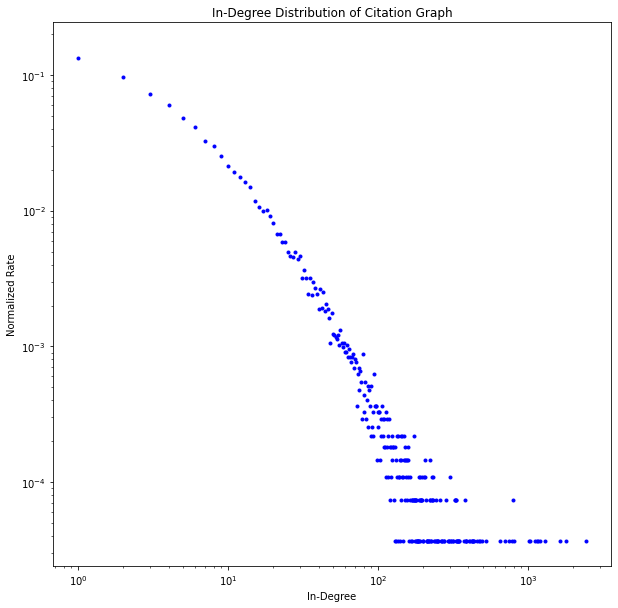

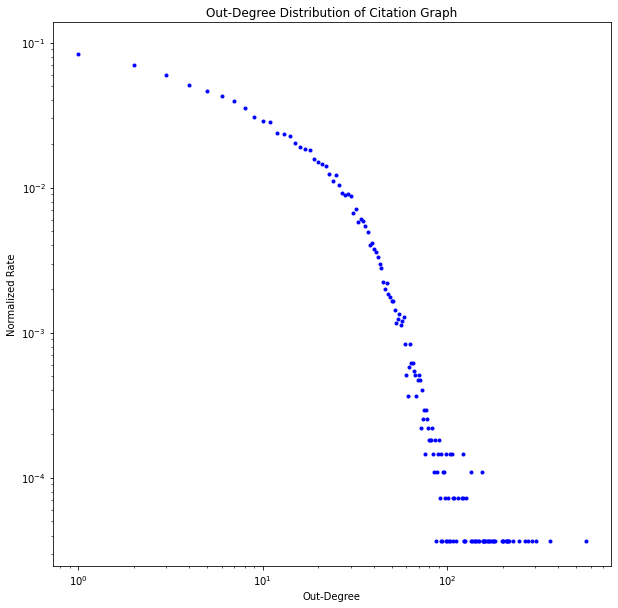

In [26]:
plot_distribution(
    in_degree_distribution,
    "In-Degree Distribution of Citation Graph",
    "In-Degree",
    filename="citations-in.png"
)

plot_distribution(
    out_degree_distribution,
    "Out-Degree Distribution of Citation Graph",
    "Out-Degree",
    filename="citations-out.png"
)

2. [15 marks] Recall the PA graph model that constructed graphs one vertex at a time.  In this model the out-degrees were all (almost) the same.  Define a version of the model where the out-degree varies in a way that is similar to the distribution found for $G$ in Question 1.  Construct instances of the model and plot the normalized distributions of the in-degree and out-degree and compare them to those of $G$.  (Your model might turn out to be a poor model for $G$.  This does not matter as long as you can motivate your definition and implement it correctly.)

In [50]:
# Adapted from topic1_PA_graphs.ipynb

class PATrial:
    def __init__(self, n_):
        self._n = n_
        self._node_numbers = [node_ for node_ in range(n_) for _ in range(n_)]

    def run_trial(self, n_):
        new_node_neighbors_ = set()
        for _ in range(n_):
            new_node_neighbors_.add(random.choice(self._node_numbers))
        self._node_numbers.extend(list(new_node_neighbors_))
        self._node_numbers.append(self._n)
        self._n += 1
        return new_node_neighbors_


def make_complete_graph(n_):
    complete_graph_ = {}
    for vertex_ in range(n_):
        complete_graph_[vertex_] = set([j_ for j_ in range(n_) if j_ != vertex_])
    return complete_graph_


def make_pa_graph(n_, out_degree_):
    pa_graph_ = make_complete_graph(out_degree_)
    trial = PATrial(out_degree_)
    for vertex in range(out_degree_, n_):
        pa_graph_[vertex] = trial.run_trial(int(out_degree_))
        # Exponentially increase the out degree
        out_degree_ *= 1.0001
    return pa_graph_

In [51]:
pa_graph: Graph = make_pa_graph(len(citation_graph), 10)

In [52]:
pa_lcc = compute_largest_connected_component(pa_graph)
print(f"Number of vertices in the largest connected component: {len(pa_lcc)}")

100%|██████████| 27770/27770 [00:18<00:00, 1508.01it/s]

Number of vertices in the largest connected component: 3853


In [53]:
pa_g: Graph = keep_nodes(pa_graph, pa_lcc)

In [54]:
pa_in_degree_dist = compute_discrete_distribution(compute_in_degrees(pa_g))
pa_out_degree_dist = compute_discrete_distribution(compute_out_degrees(pa_g))

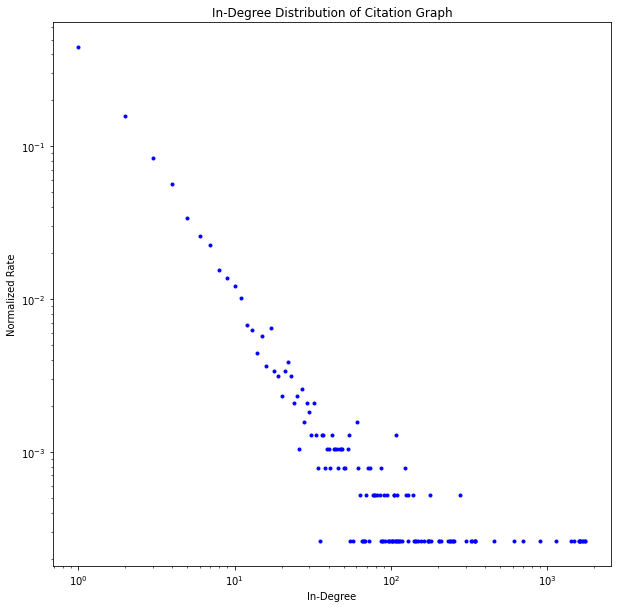

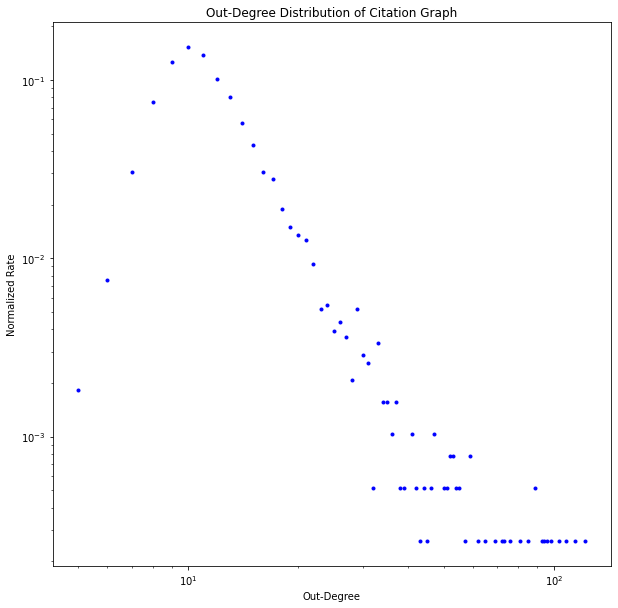

In [55]:
plot_distribution(
    pa_in_degree_dist,
    "In-Degree Distribution of Citation Graph",
    "In-Degree",
    filename="citations-in.png"
)

plot_distribution(
    pa_out_degree_dist,
    "Out-Degree Distribution of Citation Graph",
    "Out-Degree",
    filename="citations-out.png"
)

Here, as the graph is generated, the out-degree is exponentially increased for nodes beyond those in the initial complete graph.
In practice, this generates an out-degree distribution very similar to that in $G$, except for the decreasing normalised rate below an out degree of 10 (below the initial complete graph).